# Klasifikasi Gambar menggunakan CNN

Notebook ini merupakan bagian dari buku **Fundamental Machine Learning menggunakan Python** oleh **Fahmi Noor Fiqri**. Notebook ini berisi contoh kode untuk **Bab 15 - Klasifikasi Gambar: CNN.**

In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
tf.config.list_physical_devices('GPU')

2022-02-17 18:44:59.842582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-17 18:44:59.848622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-17 18:44:59.848933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Parameter training
epochs = 25
batch_size = 32
random_seed = 42

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Data Ingestion

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
train, test = tf.keras.datasets.cifar10.load_data()
ds_train = tf.data.Dataset.from_tensor_slices(train)
ds_test = tf.data.Dataset.from_tensor_slices(test)

2022-02-17 18:45:00.812857: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-17 18:45:00.814175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-17 18:45:00.814743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-17 18:45:00.815102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may hav

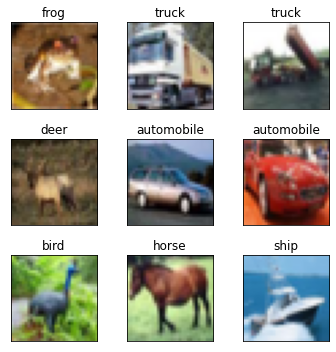

In [6]:
fig = plt.figure(figsize=(5, 5))
for i, img in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img[0].numpy())
    ax.set_xticks([])
    ax.set_yticks([])

    label = class_names[img[1].numpy().item(0)]
    ax.set_title(label)

fig.tight_layout()
plt.grid(False)

In [7]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

In [8]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(train[1].shape[0])
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [9]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Training

In [10]:
# Membuat arsitektur model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10))

In [11]:
# Kompilasi model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [12]:
# Regularization
earlystop = tf.keras.callbacks.EarlyStopping(patience=5)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [13]:
# Lakukan training menggunakan data latih
H = model.fit(ds_train, validation_data=ds_test, epochs=epochs, callbacks=callbacks)

Epoch 1/25


2022-02-17 18:45:03.449253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-17 18:45:05.292645: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-02-17 18:45:06.205882: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-17 18:45:06.239209: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-17 18:45:06.239269: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-02-17 18:45:06.274135: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-17 18:45:06.274245: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

391/391 [==============================] - 8s 9ms/step - loss: 1.5116 - accuracy: 0.4744 - val_loss: 2.3739 - val_accuracy: 0.2803
Epoch 2/25
391/391 [==============================] - 3s 7ms/step - loss: 1.0971 - accuracy: 0.6139 - val_loss: 1.0567 - val_accuracy: 0.6208
Epoch 3/25
391/391 [==============================] - 3s 7ms/step - loss: 0.9452 - accuracy: 0.6679 - val_loss: 1.1940 - val_accuracy: 0.5807
Epoch 4/25
391/391 [==============================] - 3s 6ms/step - loss: 0.8431 - accuracy: 0.7033 - val_loss: 1.0225 - val_accuracy: 0.6406
Epoch 5/25
391/391 [==============================] - 3s 7ms/step - loss: 0.7729 - accuracy: 0.7293 - val_loss: 0.9966 - val_accuracy: 0.6575
Epoch 6/25
391/391 [==============================] - 3s 7ms/step - loss: 0.7158 - accuracy: 0.7497 - val_loss: 1.4611 - val_accuracy: 0.5668
Epoch 7/25
391/391 [==============================] - 3s 7ms/step - loss: 0.6626 - accuracy: 0.7656 - val_loss: 1.1062 - val_accuracy: 0.6534

Epoch 00007: Red

## Evaluation

In [14]:
# Lakukan prediksi 
y_pred = model.predict(ds_test)
y_pred = np.argmax(y_pred, axis=1)

In [15]:
# Hitung statistik prediksi
print(classification_report(test[1], y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.76      0.78      0.77      1000
  automobile       0.84      0.86      0.85      1000
        bird       0.68      0.65      0.66      1000
         cat       0.60      0.54      0.57      1000
        deer       0.71      0.73      0.72      1000
         dog       0.72      0.62      0.67      1000
        frog       0.85      0.76      0.80      1000
       horse       0.79      0.79      0.79      1000
        ship       0.77      0.90      0.83      1000
       truck       0.75      0.88      0.81      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



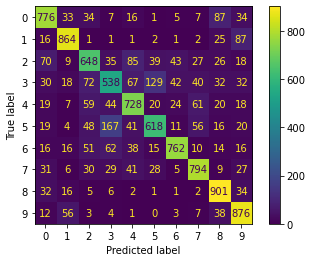

In [16]:
# Tampilkan confusion matrix
ConfusionMatrixDisplay.from_predictions(test[1], y_pred)

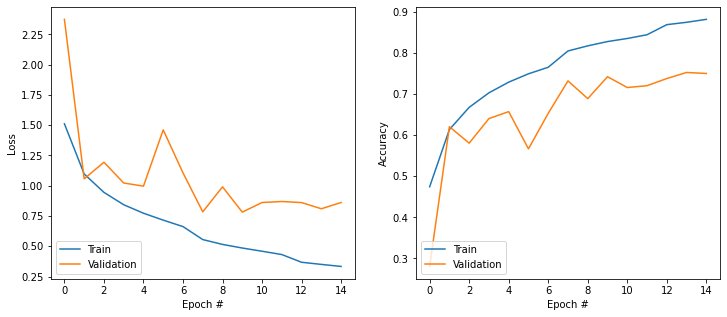

In [17]:
# Tampilkan statistik training model
plt.figure(figsize=(12, 5))

run_epochs = len(H.history['loss'])

ax1 = plt.subplot(1, 2, 1)
plt.plot(np.arange(0, run_epochs), H.history["loss"], label="Train")
plt.plot(np.arange(0, run_epochs), H.history["val_loss"], label="Validation")
ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Loss")
ax1.legend(loc="lower left")

ax2 = plt.subplot(1, 2, 2, sharex = ax1)
plt.plot(np.arange(0, run_epochs), H.history["accuracy"], label="Train")
plt.plot(np.arange(0, run_epochs), H.history["val_accuracy"], label="Validation")
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower left")

## Prediction

Text(0.5, 1.0, 'Prediksi: airplane')

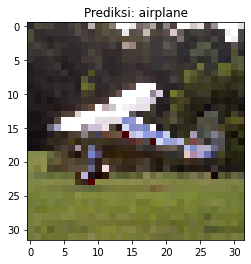

In [18]:
# Lakukan prediksi
pred_img = tf.keras.preprocessing.image.load_img('../datasets/pesawat.jpg', target_size=(32, 32))
pred_img = tf.keras.preprocessing.image.img_to_array(pred_img)
pred_img = pred_img / 255
pred_img = np.expand_dims(pred_img, axis=0)

predicted = model.predict(pred_img)
predicted = np.argmax(predicted, axis=1)[0]
inv_map = {k: v for k, v in enumerate(class_names)}
inv_map[predicted]

plt.imshow(pred_img[0])
plt.title("Prediksi: " + inv_map[predicted])

## Persistance

In [19]:
# Simpan pemetaan kelas
import joblib
joblib.dump(inv_map, '../model/cifar10_dict.joblib')

# Simpan model
import os
os.mkdir('../model/cifar10_classify')
model.save('../model/cifar10_classify')

2022-02-17 18:45:51.283174: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model/cifar10_classify/assets
